# Dimensionality Reduction

* Reducing dimensionality does cause some information loss, just like compressing an image to JPEG can degrade its quality, so even though it will speed up training, it may make your system perform slightly worse. It also makes your pipelines a bit more complex and thus harder to maintain, so first try to train your system with the original data before considering using dimensionality reduction.

# A. The Curse of Dimensionality:

* Many Things behave differently in high-dimensional space.
    * If you pick a random point in a unit square (a 1x1 square), it will have only about 0.4% chance of being located less than 0.001 from the border.( it is very unlikely that a random point will be “extreme” along any dimension). If you pick a random point in a 10,000 dimensional unit hypercube, this probability is greater than 99.999999%. Most points in a high-dimensional hypercube are very close to the border.
    * If you pick 2 points randomly in a unit square, the distance between these 2 points will be on average, roughly 0.52. If you pick 2 random points in a 3D unit cube, the average distance will be roughly 0.66. In a 1,000,000 dimensional unit hypercube, the average distance will be about 408.25.

* Since there are plenty of space in high dimensions, high-dimensional datasets are at risk of being sparse,
    * Most training instances are likely to be far away from each other.
    * A new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations.
    * The more dimensions the training set has, the greater the risk of overfitting it.

* One solution to the curse of dimensionality is to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions.

# B. Main Approaches for Dimensionality Reduction:

### B.1. Projection:

* In most real-world problems, training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated. As a result, all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional space.

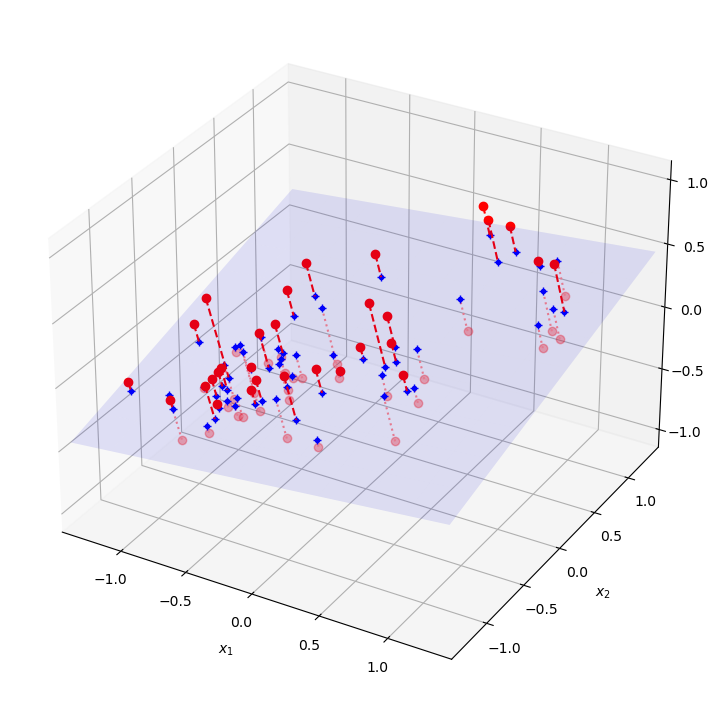

In [1]:
# Create a 3D dataset lying close to a 2D subspace

import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  
X += 0.28 * np.random.randn(m, 3)  
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  


pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  
X3D_inv = pca.inverse_transform(X2D)  
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")


ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1]);

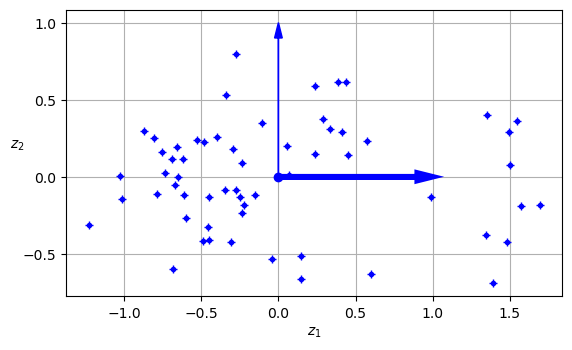

In [2]:
# New 2d Datset after projection
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True);

### B.2. Manifold Learning:

* More generally, a d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane.

* Manifold Learning:
    * Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie. It relies on the manifold assumption, also called the manifold hypothesis, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. This assumption is very often empirically observed.
    * The manifold assumption is often accompanied by another implicit assumption: that the task at hand (e.g., classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold.
    * Reducing the dimensionality of your training set before training a model will usually speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset.

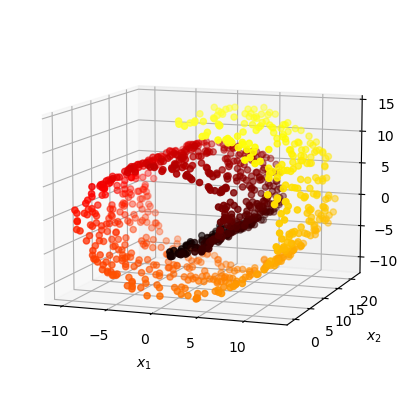

In [3]:
# Create Swiss Roll example
from sklearn.datasets import make_swiss_roll
from matplotlib.colors import ListedColormap

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)


darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes);

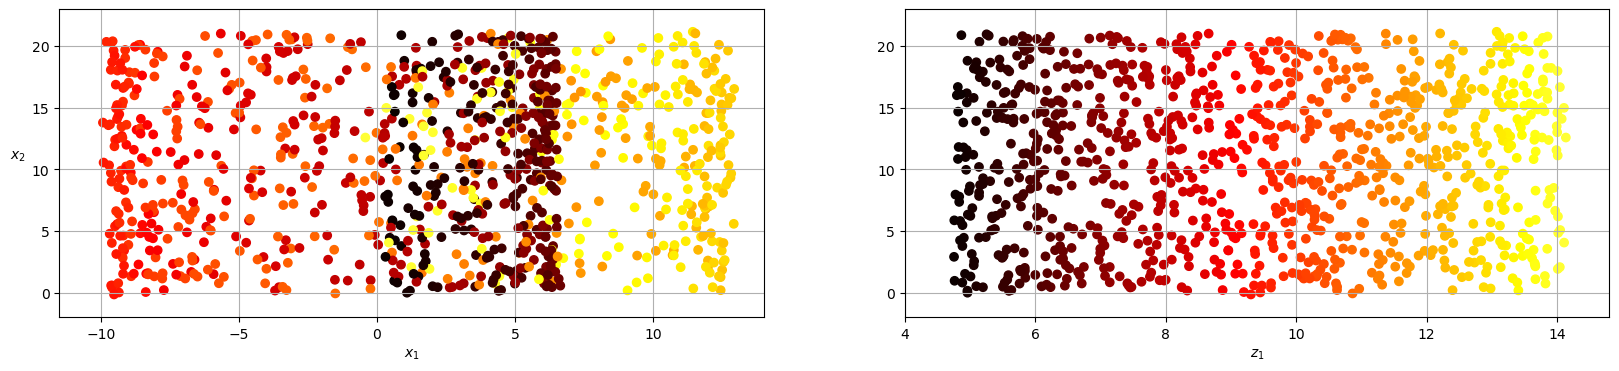

In [4]:
plt.figure(figsize=(20, 4))

# Projecting the swiss roll onto a plane
plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True);

# Unrolling the swiss roll to obtain a 2D dataset (right)
plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True);

# C.Principal Component Analysis (PCA)

### C.1. Preserving the Variance:

* Before you can project the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane. 
    * Select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. This axis will minimize the mean squared distance between the original dataset and its projection onto that axis.

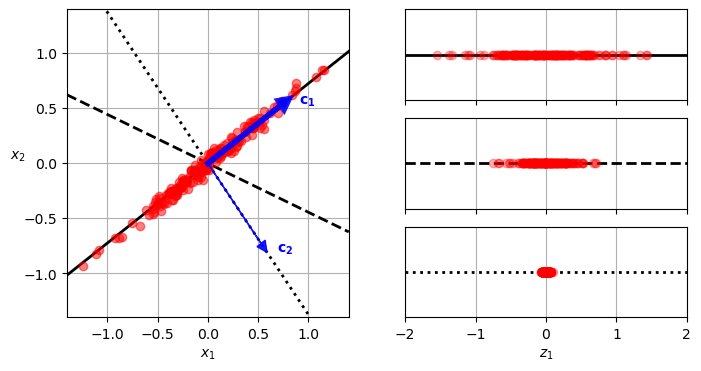

In [5]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

#1st Axis
plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

#2nd Axis
plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

#3rd Axis
plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid();

### C.2. Principal Components:

* PCA identifies the axis that accounts for the largest amount of variance in the training set.
    * It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of the remaining variance.
    * PCA would also find a third axis, orthogonal to both previous axes, and a fourth, a fifth, and so on—as many axes as the number of dimensions in the dataset.
    * The $i^{th}$ axis is called the $i^{th}$ *principal component (PC)* of the data.
    * For each principal component, PCA finds a zero-centered unit vector pointing in the direction of the PC. Since two opposing unit vectors lie on the same axis, the direction of the unit vectors returned by PCA is not stable: if you perturb the training set slightly and run PCA again, the unit vectors may point in the opposite direction as the original vectors. However, they will generally still lie on the same axes. In some cases, a pair of unit vectors may even rotate or swap (if the variances along these two axes are very close), but the plane they define will generally remain the same.

* To find the principal components of a training set, there is a standard matrix factorization technique called **Singular Value Decomposition (SVD)** that can decompose the training set matrix $X$ into the matrix multiplication of 3 matrices $U\ \sum\ V^T$, where $V$ contains the unit vectors that define all the principal components that you are looking for.

* PCA assumes that the dataset is centered around the origin. If you implement PCA yourself, or if you use other libraries, don't forget to center the data first.

In [6]:
# Using np's svd() function

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  
X += 0.28 * np.random.randn(m, 3)  
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2] 

X_centered = X-X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [7]:
# Principal Components
print(c1, c2)

[0.67857588 0.70073508 0.22023881] [-0.72817329  0.6811147   0.07646185]


### C.3. Projecting Down to $d$ Dimensions:

* Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to $d$ dimensions by projecting it onto the hyperplane defined by the first $d$ principal components.
    * Selecting this hyperplane ensures that the projection will preserve as much variance as possible.
    * To project the training set onto the hyperplane and obtain a reduced dataset, $X_{d-proj}$ of dimensionality $d$, compute the matrix multiplication of the training set matrix $X$ by the matrix $W_d$, defined as the matrix containing the first $d$ columns of $V$.
        * $X_{d-proj}\ =\ XW_d$

In [8]:
W2 = Vt[:2].T
X2D = X_centered @ W2

In [9]:
X2D

array([[-8.73231190e-01, -2.94598030e-01],
       [ 1.48885182e-01,  5.14935573e-01],
       [ 1.35121872e+00, -3.99501548e-01],
       [ 4.54366763e-01, -1.39984497e-01],
       [-7.34389086e-01, -2.28934648e-02],
       [-2.33347464e-01, -8.67844755e-02],
       [-8.08435321e-01, -2.52457557e-01],
       [ 1.48281454e+00,  4.22796305e-01],
       [ 3.85679006e-01, -6.16229365e-01],
       [ 1.54972180e+00, -3.60381563e-01],
       [-1.22938760e+00,  3.12504780e-01],
       [-4.54653275e-01,  3.28839370e-01],
       [ 1.34315899e+00,  3.79446240e-01],
       [-6.55233341e-01, -1.92367174e-01],
       [-2.49510114e-01,  1.28486810e-01],
       [-3.46562831e-01,  8.32312189e-02],
       [-6.90221113e-01, -1.13712645e-01],
       [-5.29757591e-01, -2.40403321e-01],
       [-3.96344855e-01, -2.60334107e-01],
       [-6.19519220e-01, -1.13588889e-01],
       [ 3.34910399e-01, -3.09476565e-01],
       [-4.52441114e-01,  1.28501562e-01],
       [-1.02718730e+00, -7.20555799e-03],
       [ 2.

### C.4. Using Scikit-Learn:

* Scikit-Learn’s `PCA` class uses SVD to implement PCA. It automatically takes care of centering the data.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D_pca = pca.fit_transform(X)
X2D_pca

array([[-8.73231190e-01,  2.94598030e-01],
       [ 1.48885182e-01, -5.14935573e-01],
       [ 1.35121872e+00,  3.99501548e-01],
       [ 4.54366763e-01,  1.39984497e-01],
       [-7.34389086e-01,  2.28934648e-02],
       [-2.33347464e-01,  8.67844755e-02],
       [-8.08435321e-01,  2.52457557e-01],
       [ 1.48281454e+00, -4.22796305e-01],
       [ 3.85679006e-01,  6.16229365e-01],
       [ 1.54972180e+00,  3.60381563e-01],
       [-1.22938760e+00, -3.12504780e-01],
       [-4.54653275e-01, -3.28839370e-01],
       [ 1.34315899e+00, -3.79446240e-01],
       [-6.55233341e-01,  1.92367174e-01],
       [-2.49510114e-01, -1.28486810e-01],
       [-3.46562831e-01, -8.32312189e-02],
       [-6.90221113e-01,  1.13712645e-01],
       [-5.29757591e-01,  2.40403321e-01],
       [-3.96344855e-01,  2.60334107e-01],
       [-6.19519220e-01,  1.13588889e-01],
       [ 3.34910399e-01,  3.09476565e-01],
       [-4.52441114e-01, -1.28501562e-01],
       [-1.02718730e+00,  7.20555799e-03],
       [ 2.

In [11]:
np.mean(X2D-X2D_pca)

1.27675647831893e-16

### C.5. Explained Variance:

* Explained Variance Ratio:
    * This ratio indicates the proportion of the dataset's variance that lies along each principal component.
    * Available via `explained_variance_ratio_` variable.

In [12]:
# 76% of the dataset's variance lies along the first PC and about 15% lies along the 2nd PC.
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

### C.6. Choosing the Right Number of Dimensions:

* Choose the number of dimensions that add up to a sufficiently large portion of the variance—say, 95%.
    * Instead of setting `n_components` to the number of `d` dimensions, you can set it to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve. The actual number of components is determined during training, and it is stored in the `n_components_attribute`.
    * Another option is to plot the explained variance as a function of the number of dimensions. There will usually be an elbow in the curve, where the explained variance stops growing fast.

* If you are using dimensionality reduction as a preprocessing step for a supervised learning task, then you can tune the number of dimensions as you would any other hyperparameter.

In [13]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
# return the number of dimensions that preserves 95% of the variance.
d = np.argmax(cumsum >= 0.95) + 1
d

c:\Users\JCA\anaconda3\envs\ds_ml_dl\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


154

In [14]:
# using the n_components argument to preserve 95% of the variance
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

In [15]:
pca.explained_variance_ratio_.sum()

0.9501960192613034

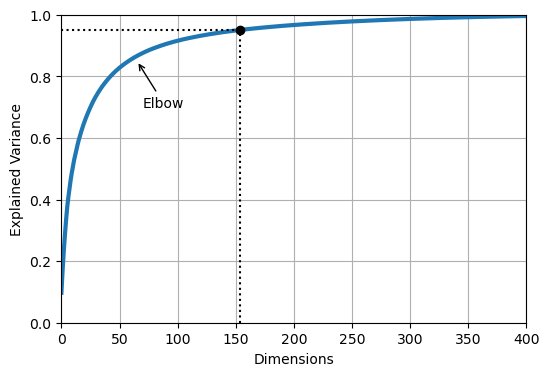

In [16]:
# Elbow method
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True);

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    PCA(random_state=42),
    RandomForestClassifier(random_state=42)
)

param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}

rnd_search = RandomizedSearchCV(
    clf, 
    param_distrib, 
    n_iter=10, cv=3,
    random_state=42
)

In [18]:
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [19]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(
    PCA(random_state=42), 
    SGDClassifier()
)

param_grid = {
    "pca__n_components": np.arange(10, 80)
}

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [21]:
grid_search.best_params_

{'pca__n_components': 60}

### C.7. PCA for Compression:

* After dimensionality reduction, the training set takes up much less space.
* It is also possible to decompress the reduced dataset back to the original dimensions by applying the inverse transformation of the PCA projection.
    * This won’t give you back the original data, since the projection lost a bit of information , but it will likely be close to the original data.
    * The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the **reconstruction error**.

* The `inverse_transform()` method lets us decompress the reduced dataset back to the original dimensions.
    * PCA inverse transformation:
    &emsp; $X_{recovered}\ =\ X_{d-proj}W_d^T$

In [22]:
pca = PCA(0.95)

X_reduced = pca.fit_transform(X_train, y_train)
X_recovered = pca.inverse_transform(X_reduced)

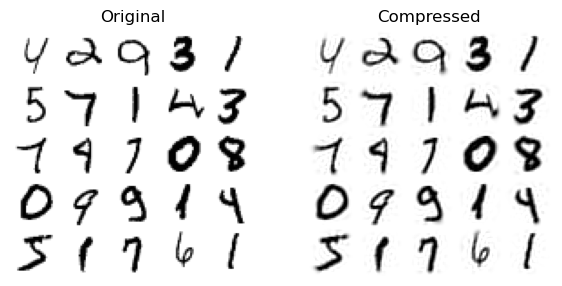

In [23]:
plt.figure(figsize=(7, 4))

for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")



### C.8. Randomized PCA:

* Scikit-Learn uses a stochastic algorithm called randomized PCA that quickly finds an approximation of the first *d* principal components. This is implemented by default, (set `svd_solver="randomized"` or `svd_solver="auto"` ). 
    * Scikit-Learn automatically uses the randomized PCA algorithm if max(m, n) > 500 and `n_components` is an integer smaller than 80% of min(m, n), or else it uses the full SVD approach.
    * Its computational complexity is $O(m\ x\ d^2)\ +\ O(d^3)$, instead of $O(m\ x\ n^2)\ +\ O(n^3)$ for the full SVD approach. This is faster than full SVD when $d$ is much smaller than m.

* To use full SVD for a slightly more precise result, set the `svd_solver` hyperparameter to `"full"`.

In [24]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### C.9. Incremental PCA:

* Incremental PCA (IPCA) algorithms have been developed that allow you to split the training set into mini-batches and feed these in one mini-batch at a time. This is useful for large training sets and for applying PCA online (i.e., on the fly, as new instances arrive).
* Methods in implementing Incremental PCA:
    * By using numpy's `np.array_split()` function to split the training set into mini-batches and feeding it to sklearn's `IncrementalPCA` class to reduce the dimensionality of the dataset. Must call the `partial_fit()` w/ each mini-batch, rather than the `fit()` method w/ the whole training set.

    * By using numpy's `memmap` class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory, when it needs it.In real life, the training set would typically not fit in memory, so you would load it chunk by chunk and save each chunk to the right part of the memmap array.
        * After saving the `memmap` file, load it and use it like a regular numpy array. Since this algorithm uses only a small part of the array at any given time, memory usage remains under control. This makes it possible to call the usual `fit()` method instead of `partial_fit()`.
        * Only the raw binary data is saved to disk, so you need to specify the data type and shape of the array when you load it. If you omit the shape, `np.memmap()` returns a 1D array.

In [25]:
# np.array_split + IncrementalPCA
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [26]:
# np.memmap + IncrementalPCA

filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # could be a loop instead, saving the data chunk by chunk
# ensure that any data still in the cache gets saved to disk
X_mmap.flush()

In [27]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

# D. Random Projection:

* For very high-dimensional datasets, PCA can be too slow. If dealing with adataset with tens of thousands of features or more (e.g., images), then training may become much too slow: in this case, consider using random projection instead.

* Random projection algorithm projects the data to a lower-dimensional space using a random linear projection.
    * Such a random projection is actually very likely to preserve distances fairly well, but the more dimensions you drop, the more information is lost, and the more distances get distorted.

* How to choose the optimal number of dimensions?
    * Using `sklearn.random_projection`'s `johnson_lindenstrauss_min_dim`. This function (or equation) determines the number of dimensions to preserve in order to ensure (w/ high probability) that distances won't change by more than a given tolerance.
        * For example, if a dataset contains m = 5000 instances w/ n = 20000 features each, and you don't want the squared distance between any 2 instances to change by more than $\epsilon$ = 10%, then you project the data down to $d$ dimensions, w/ $\Large d\ \leq\ \frac{4\ log(m)}{\frac{1}{2}\epsilon^2\ -\ \frac{1}{2}\epsilon^3}$, w/c is 7,300 dimensions or features.
        * Then generate a random matrix $P$ of shape $[d, n]$, where each item is sampled randomly from a Gaussian distribution w/ mean =0 and variance = $\frac{1}{d}$, and use it to project a dataset from n dimensions down to d.

    * Or use, sklearn's API : `GaussianRandomProjection` class:
        * When `fit()` method is called, it uses `johnson_lindenstrauss_min_dim` to determine the output dimensionality, then it generates a random matrix w/c stores in the `component_` attribute.
        * When `transform()` method is called, it uses matrix to perform the projection.

    * `SparseRandomProjection`:
        * Determines the target dimensionality the same way as `GaussianRandomProjection`, generates a random matrix of the same shape, and performs the projection identically, but the random matrix is sparse.
        * Uses much less memory and faster in generating random matrix and in reducing dimensionality.
        * If the input is spares, the transformation keeps it sparse (can be changed by setting `dense_ouput`).
        * It's usually a more preferable transfomer especially for large or sparse dataset.
        * The ratio $r$ of nonzero items in the sparse random matrix is called its *density*.
            * By default, density is equal to $\frac{1}{\sqrt(n)}$. But the `density` hyperparameter can be changed.
        * Each cell in the sparse random matrix has probability $r$ of being nonzero, and each nonzero value is $\pm v$, where $v\ = \frac{1}{\sqrt(dr)}$.
        * To perform inverse transformation, compute the pseudoinverse of the components using SciPy's `pinv()` function then multiply the reduced data by the transpose of the pseudo-inverse.
            * `pinv()` computational complexity is $O(dn^2) if\ d<n$ or $O(nd^2)$ otherwise.


In [28]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, eps = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=eps)
d 

7300

In [30]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)
X = np.random.randn(m, n) # generate sample dataset
X_reduced = X @ P.T

In [32]:
print(f"Original Shape:{X.shape} reduced to {X_reduced.shape}")

Original Shape:(5000, 20000) reduced to (5000, 7300)


In [33]:
from sklearn.random_projection import GaussianRandomProjection

gauss_rnd_proj = GaussianRandomProjection(eps=eps, random_state=42)
X_reduced2 = gauss_rnd_proj.fit_transform(X)
print(f"Original Shape:{X.shape} reduced to {X_reduced2.shape}")

Original Shape:(5000, 20000) reduced to (5000, 7300)


In [35]:
# compute pseudo-inverse

components_pinv = np.linalg.pinv(gauss_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

In [36]:
X_recovered.shape

(5000, 20000)

In [37]:
from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
4 s ± 158 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
3.11 s ± 72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
12 s ± 408 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
8.06 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# E. LLE (Locally Linear Embedding):
 
* Locally Linear Embedding is a nonlinear dimensionality reduction (NLDR) technique. It is a manifold learning technique that does not rely on projections, unlike PCA and random projection.
    * LLE works by first measuring how each training instance linearly relates to its nearest neighbors, and then looking for a low-dimensional representation of the training set where these local relationships are best preserved .
    * This approach makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.

* How LLE Works:
    * For each training instance ,$x^{(i)}$, the algortihm identifies its k-nearest neighbors, then it reconstruct $x^{(i)}$ as a linear function of these neighbors. It tries to find the weights ,$w_{i,j}$, such that the squared distance between $x^{(i)}$ and $\sum_{j=1}^m\ w_{i,j}\ x^{(j)}$ is as small as possible, assuming $w_{i,j}\ =\ 0$ if $x^{(f)}$ is not one of the k-nearest neighbors of $x^{(i)}$

    * LLE scales poorly to very large datasets, but it can also contruct much better low-dimensional representations, especially if the data is nonliner.

In [38]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

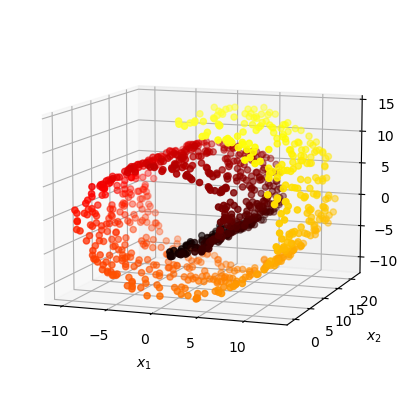

In [39]:
# Original Swiss Roll
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes);

Text(0.5, 1.0, 'Unrolled swiss roll using LLE')

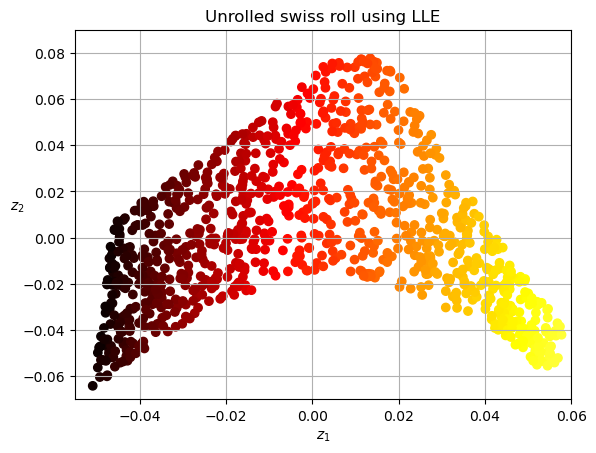

In [40]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)
plt.title("Unrolled swiss roll using LLE")


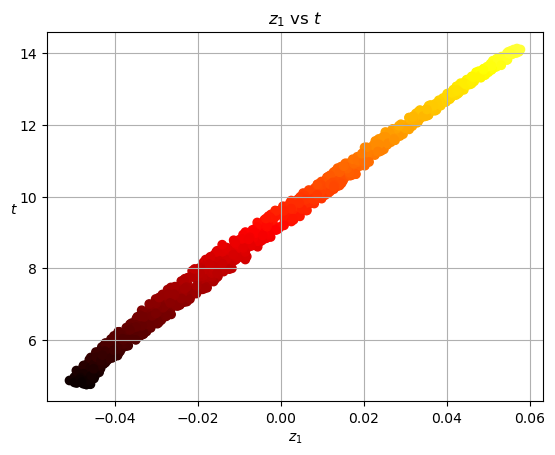

In [41]:
# Correlation of z1 and t
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True);

# F. Other Dimensionality Reduction Techniques:

* `sklearn.manifold.MDS`:
    * Multidimensional scaling (MDS) reduces dimensionality while trying to preserve the distances between the instances. Random projection does that for highdimensional data, but it doesn’t work well on low-dimensional data.

* `sklearn.manifold.Isomap`:
    * Isomap creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances between the instances. The geodesic distance between two nodes in a graph is the number of nodes on the shortest path between these nodes.

* `sklearn.manifold.TSNE`:
    * t-distributed stochastic neighbor embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high dimensional space.

* `sklearn.discriminant_analysis.LinearDiscriminantAnalysis`:
    * Linear discriminant analysis (LDA) is a linear classification algorithm that, during training, learns the most discriminative axes between the classes. These axes can then be used to define a hyperplane onto which to project the data. The benefit of this approach is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm (unless LDA alone is sufficient).

In [42]:
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

c:\Users\JCA\anaconda3\envs\ds_ml_dl\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


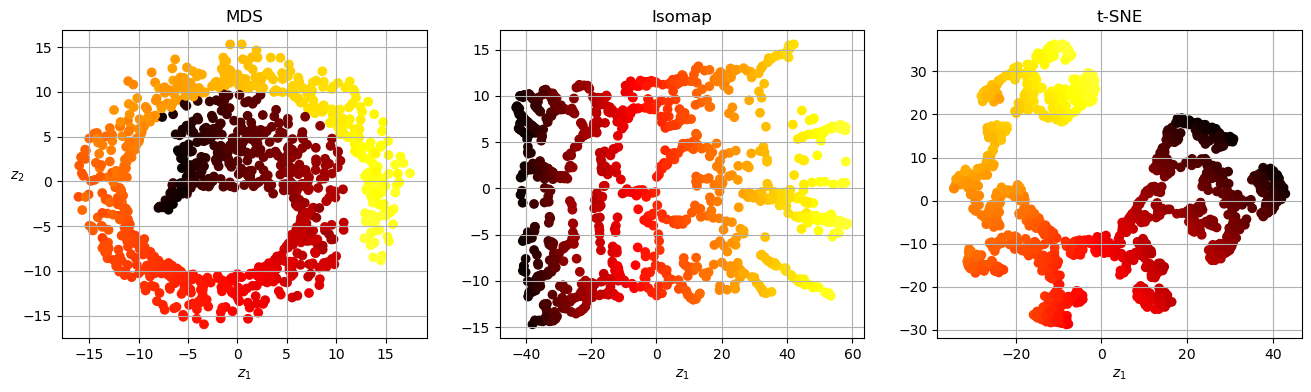

In [45]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(16, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles, (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

